# Project Part 2

# 1 Bandits

# 1.1 Formalizing the problem as a multi-armed bandits problem

For this bandit problem we will use the different street corners/areas as different arms to pull on.  We can't measure direct "recruitment" so our reward for this problem will have to be number of flyers handed out.  


Our time horizon will be over an entire year given the data that we have.

Our rewards are bounded by the maximum number of people who pass by a given street corner for a given day.  They could also bounded by the number of flyers that one is given to hand out.

Here our notion of regret will be handing out the less than optimal number of flyers for the best corner at a given time.  Our strategy will be narrowing down to an "overall" best corner that we will almost continually use but the pure optimal strategy will differ by the day of the week.  It is really closer to a pseudo regret where we're just measuring against the highest average number of riders rather than a more "true" regret that accounts for time of year and number of non registered riders.

It's reasonable to assume that there are in fact a maximum number of flyers to hand out.  We have humans working and handing out flyers so we can't assume that they could work forever or even hand out as many flyers as people walking by for a given period of time.  However it can not be said that the distribution will be fixed over time.  As businesses go in and out, neighborhoods change, it can not be directly assumed that even the number of flyers handed out can always be part of the same distribution.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import functools
from Bandit_env import BanditEnv, Interactive_UCB_Algorithm,Interactive_TS_Algorithm

# 1.2 Simulate UCB strategy using past data

In [2]:
# import city data
ny = pd.read_csv('./ny.csv')
chi = pd.read_csv('./chicago.csv') 
dc = pd.read_csv('./dc.csv')

In [3]:
# transform 
dc['Start date'] = pd.to_datetime(dc['Start date'])
ny['starttime'] = pd.to_datetime(ny['starttime']) 
chi['starttime'] = pd.to_datetime(chi['starttime'])

ny['dteday'] = np.array([ny['starttime'][i].date() for i in range(len(ny))])
dc['dteday'] = np.array([dc['Start date'][i].date() for i in range(len(dc))])
chi['dteday'] = np.array([chi['starttime'][i].date() for i in range(len(chi))])

In [4]:
# for each date and station, group beginnings and endings
ny['start_count'] = np.ones((len(ny), 1))
dc['start_count'] = np.ones((len(dc), 1))
chi['start_count'] = np.ones((len(chi), 1))

ny['end_count'] = np.ones((len(ny), 1))
dc['end_count'] = np.ones((len(dc), 1))
chi['end_count'] = np.ones((len(chi), 1))



ny_start = ny.groupby(['start station name', 'dteday'])['start_count'].agg('count').reset_index()
dc_start = dc.groupby(['Start station', 'dteday'])['start_count'].agg('count').reset_index()
chi_start = chi.groupby(['from_station_name', 'dteday'])['start_count'].agg('count').reset_index()

ny_end = ny.groupby(['end station name', 'dteday'])['end_count'].agg('count').reset_index()
dc_end = dc.groupby(['End station', 'dteday'])['end_count'].agg('count').reset_index()
chi_end = chi.groupby(['to_station_name', 'dteday'])['end_count'].agg('count').reset_index()

# rename columns so we can merge
ny_end = ny_end.rename(columns = {'end station name':'start station name', 'dteday':'dteday', 'end_count':'end_count'})
dc_end = dc_end.rename(columns = {'End station':'Start station', 'dteday':'dteday', 'end_count':'end_count'})
chi_end = chi_end.rename(columns = {'to_station_name':'from_station_name', 'dteday':'dteday', 'end_count':'end_count'})

# merge the two sets
ny_merge = pd.merge(ny_start, ny_end, on = ['start station name', 'dteday'], how = 'outer').fillna(value = 0)
dc_merge = pd.merge(dc_start, dc_end, on = ['Start station', 'dteday'], how = 'outer').fillna(value = 0)
chi_merge = pd.merge(chi_start, chi_end, on = ['from_station_name', 'dteday'], how = 'outer').fillna(value = 0)

ny_merge['total'] = ny_merge['start_count'] + ny_merge['end_count']
dc_merge['total'] = dc_merge['start_count'] + dc_merge['end_count']
chi_merge['total'] = chi_merge['start_count'] + chi_merge['end_count']

top_ny = ny_merge.groupby('start station name')['total'].sum().reset_index().sort_values('total', ascending = False).head(10)
top_dc = dc_merge.groupby('Start station')['total'].sum().reset_index().sort_values('total', ascending = False).head(10)
top_chi = chi_merge.groupby('from_station_name')['total'].sum().reset_index().sort_values('total', ascending = False).head(10)

# narrow down to only be rides from our 10 highest rider stations
ny_merge = ny_merge[ny_merge['start station name'].isin(top_ny['start station name'].values)]
dc_merge = dc_merge[dc_merge['Start station'].isin(top_dc['Start station'].values)]
chi_merge = chi_merge[chi_merge['from_station_name'].isin(top_chi['from_station_name'].values)]

We have grouped our data by station and day but there are a number of stations who do not receive any riders coming or going for an entire day and our groupby functionality does not include these missing days so we need to go through and impute them ourselves. 

For each city dataset we will go through each top 10 list and for the entire span of unique dates in that given city set, add 0 values for any dates that are missing.  

In [5]:
# prepare the rewards data
# for each of the 10 stations, insert 0s for missing dates 
# create copy of the desired rewards station first 
sets = [ny_merge, dc_merge, chi_merge]
city = []

for i in sets:
    unique_dates = i['dteday'].unique()
    unique_stations = i.iloc[:, 0].unique()
    streets = []
    for j in unique_stations:
        df = i.loc[i.iloc[:, 0] == j].set_index('dteday')
        rewards_list = df.reindex(unique_dates, fill_value=0)['total']
        
        streets.append(rewards_list)
    
    city.append(streets)
    

## 1.2.1 Implementation and Results

Here we are implementing the UCB bandit algorithm for determining the best locations to distribute flyers. We've narrowed it down to 10 of the most popular corners in a given city.  We imagine each corner being like an arm of a slot machine, when we pull each one we learn a bit more about its distribution thanks to a 'randomly' distributed reward.  For each iteration/pull we decide to pick the arm with the highest upper confidence bound. At each iteration we take the rewards data we've collected on each arm up to that point to construct Chernoff bounds. To ensure exploration is guaranteed, any arm that has not been pulled has an assigned upper bound of infinity.  We are assuming bounded rewards considering that we're working with since there should be a reasonable limit to the number of flyers that can be handed out by one person in one day.  The width of the bound here depends on both the type of bound you use which is heavily dependent on your assumptions of the reward space.

We will implement the UCB algorithm for each of the three cities and visualize both the regret (accumulated difference between the algorithm arm choice and the optimal arm) as well as upper confidence bounds for each of the arms over their span.

In [6]:
def UCB_pull_arm(t,variance,times_pulled,rewards):
    """ 
    Implement the choice of arm for the UCB algorithm
    
    Inputs:
    iteration          - iteration of the bandit algorithm
    times_pulled       - a list of length K (where K is the number of arms) of the number of 
                         times each arm has been pulled
    rewards            - a list of K lists. Each of the K lists holds the samples received from pulling each arm up 
                         to iteration t. 
    
    Returns:
    arm                -  integer representing the arm that the UCB algorithm would choose.
    confidence bounds  -  a list of the upper confidence bounds for each arm
    """

    K=len(times_pulled)
    delta=1.0/t**2
    
    confidence_bounds=[]
    for k in range(K):
        if times_pulled[k] == 0:
            confidence_bounds.append(np.Infinity)
        else:
            confidence_bounds.append(np.mean(rewards[k]) + np.sqrt(2 * variance * np.log(1 / delta) / (times_pulled[k])))
            
    arm=np.argmax(confidence_bounds)
    
    return arm , confidence_bounds

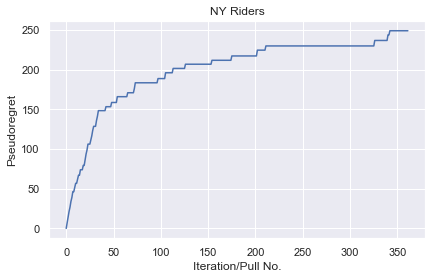

In [7]:
means=[np.mean(city[0][i]) for i in range(len(city[0]))]
variance=8
standard_deviations=[np.sqrt(variance) for arm in range(len(means))]
bandit_env=BanditEnv(means,standard_deviations)
# need to store bounds
bounds = [[], [], [], [], [], [], [], [], [], []]
#Initialize pseudo-regret
UCB_pseudo_regret=0
for runs in range(1):
    #Initialize Bandit_environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,len(ny_merge['dteday'].unique())):
        #Choose arm using UCB algorithm
        arm,confidence_bounds=UCB_pull_arm(t, variance, bandit_env.times_pulled, [city[0][i].tolist()[:t] for i in range(10)] )
        bounds[np.argmax(confidence_bounds)].append(confidence_bounds[np.argmax(confidence_bounds)])
        #Pull Arm
        bandit_env.pull_arm(arm)
        
    #Keep track of pseudo-regret  
    UCB_pseudo_regret+=np.array(bandit_env.regret)
bounds = np.array(bounds)
#Make plot
plt.plot(UCB_pseudo_regret/1)
plt.xlabel('Iteration/Pull No.')
plt.ylabel('Pseudoregret')
plt.title('NY Riders')
plt.show()

Text(0.5, 1.0, 'UCB upper bounds through iterations NY')

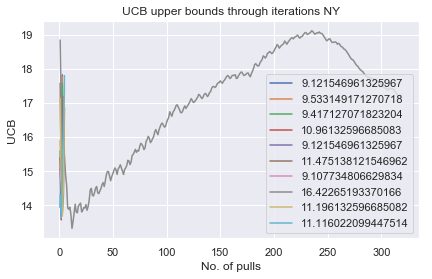

In [8]:
for i in range(10):
    plt.plot(bounds[i], label = means[i])

plt.legend()
plt.xlabel('No. of pulls')
plt.ylabel('UCB')
plt.title('UCB upper bounds through iterations NY')

I was having difficulty implementing the UCB data in the way that I wanted to but I believe that this paints the general picture as to what ends up happening in the algorithm.  There is some sway back and forth at the beginning between several of the arms but in the end the highest mean arm gets pulled a considerable amount more leading to the kind of logarithmic pseudo regret that we get to see above.

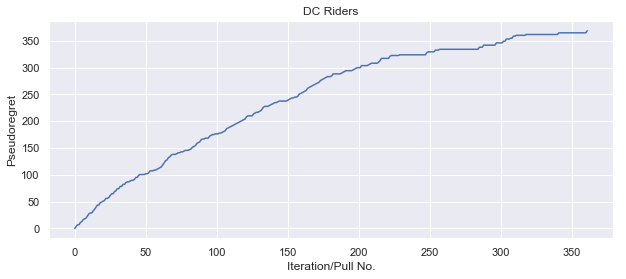

In [9]:
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

means=[np.mean(city[1][i]) for i in range(len(city[1]))]
variance=8
standard_deviations=[np.sqrt(variance) for arm in range(len(means))]
bandit_env=BanditEnv(means,standard_deviations)
# store bounds
bounds = [[], [], [], [], [], [], [], [], [], []]
#Initialize pseudo-regret
UCB_pseudo_regret=0
for runs in range(1):
    #Initialize Bandit_environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,len(ny_merge['dteday'].unique())):
        #Choose arm using UCB algorithm
        arm,confidence_bounds=UCB_pull_arm(t, variance, bandit_env.times_pulled, [city[1][i].tolist()[:t] for i in range(10)] )
        bounds[np.argmax(confidence_bounds)].append(confidence_bounds[np.argmax(confidence_bounds)])
        #Pull Arm
        bandit_env.pull_arm(arm)
        
    #Keep track of pseudo-regret  
    UCB_pseudo_regret+=np.array(bandit_env.regret)
bounds = np.array(bounds)
#Make plot
plt.plot(UCB_pseudo_regret/1)
plt.xlabel('Iteration/Pull No.')
plt.ylabel('Pseudoregret')
plt.title('DC Riders')
plt.show()

Text(0.5, 1.0, 'UCB upper bounds through iterations DC')

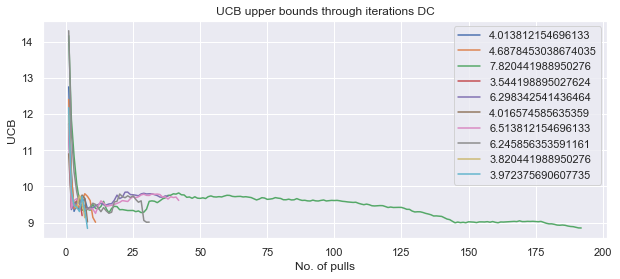

In [10]:
for i in range(10):
    plt.plot(bounds[i], label = means[i])

plt.legend()
plt.xlabel('No. of pulls')
plt.ylabel('UCB')
plt.title('UCB upper bounds through iterations DC')

Now with the DC set we have a situation where there is not such a large gap between the highest and second highest mean arm.  That shows itself in the overall number of pulls or length that is expressed in the pink line, but in the end the highest mean arm gets pulled a significant amount more than the rest.

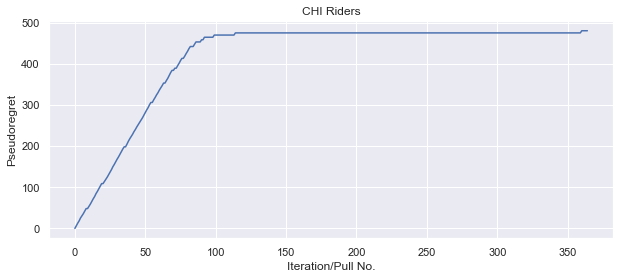

In [11]:
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

means=[np.mean(city[2][i]) for i in range(len(city[2]))]
variance=8
standard_deviations=[np.sqrt(variance) for arm in range(len(means))]
bandit_env=BanditEnv(means,standard_deviations)
# store bounds
bounds = [[], [], [], [], [], [], [], [], [], []]
mus = []
#Initialize pseudo-regret
UCB_pseudo_regret=0
for runs in range(1):
    #Initialize Bandit_environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,len(chi_merge['dteday'].unique())):
        #Choose arm using UCB algorithm
        arm,confidence_bounds=UCB_pull_arm(t, variance, bandit_env.times_pulled, [city[2][i].tolist()[:t] for i in range(10)] )
        bounds[np.argmax(confidence_bounds)].append(confidence_bounds[np.argmax(confidence_bounds)])
        #Pull Arm
        bandit_env.pull_arm(arm)
        mus.append([np.mean(city[2][i].tolist()[:t]) for i in range(10)])
    #Keep track of pseudo-regret  
    UCB_pseudo_regret+=np.array(bandit_env.regret)
bounds = np.array(bounds)
mus = np.array(mus).reshape(10, 364)
#Make plot
plt.plot(UCB_pseudo_regret/1)
plt.xlabel('Iteration/Pull No.')
plt.ylabel('Pseudoregret')
plt.title('CHI Riders')
plt.show()

Text(0.5, 1.0, 'UCB upper bounds through iterations CHI')

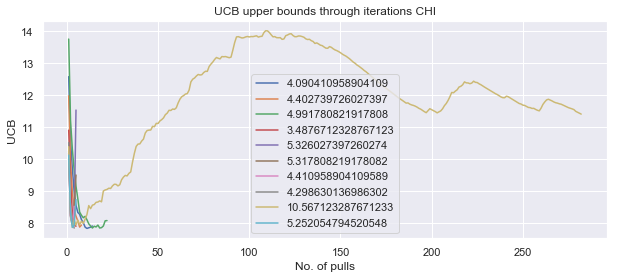

In [12]:
for i in range(10):
    plt.plot(bounds[i], label = means[i])

plt.legend()
plt.xlabel('No. of pulls')
plt.ylabel('UCB')
plt.title('UCB upper bounds through iterations CHI')

In the Chicago set we have our optimal arm being nearly twice as large as any of the others and it shows in the pseudo regret completely flattening at around the 100th pull.  The data as we are feeding it in is ordered by date so up to any date of time we are in essence not capturing from random distributions but just giving in all the data we have up to a certain time of year.  That's why we see this peaking form in each of the city UCB graphs because we're capturing the upper bound of summer months when we know there are more riders.  

## 1.2.2 Discussion

Considering the temporal setting of our data we aren't really pulling from a random distribution.  Maybe if we were to randomly sample from all the ride counts from any date we'd see some drastically different results but not for this exercise.  The only other case might be in our DC set where there is not much difference between the highest and second highest arms, we could land in a situation where it might take a long time before we opt for the optimal arm.

Here in this exercise we have defined regret as being not choosing the arm with highest average value.  As good as that might seem it doesn't meet any rigorous optimality checks especially considering what we know about the data.  We know there are up periods for rentals and down periods, marked pretty significantly by either being warm or cold weather months.  We also know that there are tracked subscribed and non subscribed riders, and not counting the subscribed riders would be useful if you want to hand out flyers to future new customers.  Before we would go any further we'd only want to be considering patterns of non subscribed riders and have an algorithm that adjusts for seasonal differences that we know have a large effect on rider behaviors.

## 1.3 Takeaways

As far as moving towards a general answer of which corner was actually the best, we can find a clear best (if there is a clear gap) in a matter of a few months worth of data.  However this assumption does not always optimize for the given time of year, it mostly just worked out quite well for us in this case.  The choice of best arm is susceptible to noise in the early part of the year and what appears to be best in the early part of the year is not necessarily the best in the spring, summer, or fall.  And here for us "best" is just an average that doesn't discern between riders who already take part in the program nor does it point us to a number of pedestrians.  Our bandit algorithm here is able to find the most travelled corner by riders in a matter of a few months if there are clear differences betwen street corners.  

If this is the task that someone wishes to have information about then yes the multi-armed bandit works. We can't necessarily hold any assumptions on the distribution of rewards being fixed as there a number of factors that can change foot traffic in a given area.  We also know that rewards of pulls of the arm are not independent, they're heavily dependent on the iteration of the algorithm as it's directly related to the time of year the data is concerned with.   


I believe that the UCB algorithm would be highly beneficial in finding the best corner for someone to hand out flyers.  But if we want to get down to a more realistic sense of effectivness in terms of handing out flyers we have to massage our data a bit more.  I'd first want some kind of confirmation that there is a strong relationship between the number of riders and foot traffic for a given area. I'd also want to make sure that this kind of analysis is being done with non registered riders as I'm presuming you're handing out flyers to register people for the rental service.  In addition to ensure our bandits are not making the wrong assumption of best arm, there should be work done ensuring that the algorithm is not thrown off by the data in the early year or confirm that the most popular stations in the winter are the same as those in the spring and summer months.   

# 2 Privacy Concerns

# 2.1 Exploratory Analysis

In [13]:
leaked = pd.read_csv('./leaked.csv')
berkeley = pd.read_csv('./berkeley.csv')

Before we go any further we first want to run some exploratory analysis on our leaked dataset.  Let's start with some visualizations.

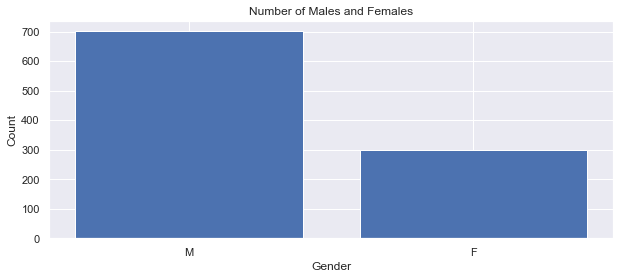

In [15]:
plt.bar(leaked['sex'].value_counts().index, leaked['sex'].value_counts()[:])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Number of Males and Females')
plt.show()

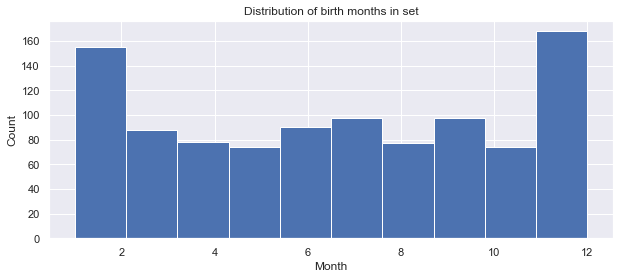

In [16]:
# plot the distribution of birth months
plt.hist(leaked['month'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Distribution of birth months in set')
plt.show()

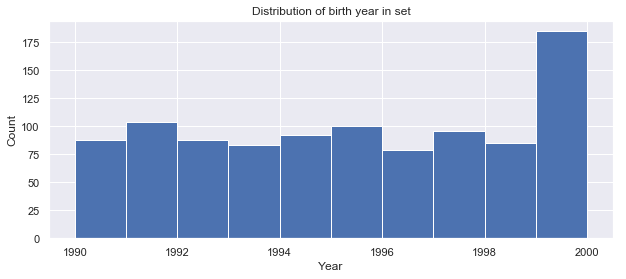

In [17]:
# plot the distribution of birth years in the set
plt.hist(leaked['year'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of birth year in set')
plt.show()

First off we can see that we have a predominately higher set of males in the set as was the case earlier on in the project.  But moving on to both the distribution of birth months and years we have some skewness on the ends.  With the birth months January and December are drastically higher, in the birth years there's a much more predominate young crowd.

# 2.2 Simple Proof of Concept

In [18]:
# stitch together our sex month and year into one value
leaked['stitch'] = np.array([str(leaked['sex'][i]) + str(leaked['month'][i]) + str(leaked['year'][i]) for i in range(len(leaked))])

In [19]:
# take value counts of this stitched column to find the unique combination of variables in our set
a = leaked['stitch'].value_counts()
uniq = a[a == 1]

In [20]:
# grab unique rows in our leaked set
uniq_leaked = leaked[leaked['stitch'].isin(uniq.index)]
len(uniq_leaked)

43

Here we have 43 users that can be uniquely identified by sex, birth year, and birth month.

Let's take a look at the gender distribution again, this time in our uniquely identifiable users.

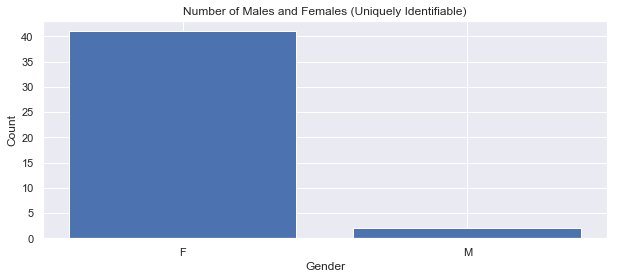

In [21]:
plt.bar(uniq_leaked['sex'].value_counts().index, uniq_leaked['sex'].value_counts()[:])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Number of Males and Females (Uniquely Identifiable)')
plt.show()

We now have a great gender imbalance.  We saw earlier that overall there was a much greater proportion of of male to female riders and now we see it flipped, albeit in smaller numbers.  We have the gender balance flipped for the uniquely identifiable users.

Let's check birth months.

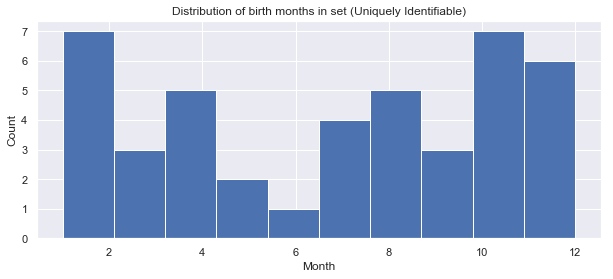

In [22]:
plt.hist(uniq_leaked['month'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Distribution of birth months in set (Uniquely Identifiable)')
plt.show()

Not so uniform here, or at least a little dissimilar from the whole population of birth months.  We have a high number of January and December birthdays but the rest of the distribution is not so uniform here.  We're looking at a much smaller set of users so there's not much of an idea as to whether or not this distribution will hold with more uniquely identifiable users.  

Here we'll write a function to be able to replicate finding the full set of these unique rides.

In [23]:
# write a function
def grab_unique(df):
    df['stitch'] = np.array([str(df['sex'][i]) + str(df['month'][i]) + str(df['year'][i]) for i in range(len(df))])
    a = df['stitch'].value_counts()
    uniq = a[a == 1]
    uniq_leaked = df[df['stitch'].isin(uniq.index)]
    uniq_merge = pd.merge(uniq_leaked, berkeley, on = ['sex', 'month', 'year'])
    uniq_merge.drop(columns = ['stitch'], inplace = True)
    return uniq_merge

# 2.3 A More Elaborate Attack

In [24]:
# using trips made by our identifiable users, estimate p1 and p2 for the set 
ided = grab_unique(leaked)
ided['1'] = np.array([1 if (ided['start'][i] != ided['zip'][i]) else 0 for i in range(len(ided))])
ided['2'] = np.array([1 if (ided['end'][i] != ided['zip'][i]) else 0 for i in range(len(ided))])

To get the MLE of p_1 and p_2 we will run a binomial experiment with N trials n times.  We will take the sum of N binomial distributions of size N and divide this by N^2 to generate the MLE bernouli variable.

In [25]:
# run binomial experiment for p_1
s = 0
for i in range(len(ided)):
    s += np.sum(np.random.binomial(n = len(ided), p = np.mean(ided['1'])))
p_1 = s / (len(ided)**2)

# run binomial experiment for p_2
t = 0
for i in range(len(ided)):
    t += np.sum(np.random.binomial(n = len(ided), p = np.mean(ided['2'])))
p_2 = t / (len(ided)**2)

print(p_1)
print(p_2)

0.09659493729464574
0.27860572498084646


And since we're working with a Bernouli variable where neither of our p_1 or p_2 is significantly close to 0 or 1 and we have a sufficiently large sample size, we can estimate the confidence interval with a normal distribution where the variance is p(1 - p).

In [26]:
ci_p1 = ((p_1) - (2 * np.sqrt((p_1 * (1 - p_1)) / len(ided))), (p_1) + (2 * np.sqrt((p_1 * (1 - p_1)) / len(ided))))
ci_p2 = ((p_2) - (2 * np.sqrt((p_2 * (1 - p_2)) / len(ided))), (p_2) + (2 * np.sqrt((p_2 * (1 - p_2)) / len(ided))))
print(ci_p1)
print(ci_p2)

(0.08401309778274245, 0.10917677680654904)
(0.2595112789700216, 0.29770017099167134)


Now let's go back to our list of uniquely identifiable users but this time seeing how our list expands when we include zip code as one of the features.

In [27]:
leaked['stitch'] = np.array([str(leaked['sex'][i]) + str(leaked['month'][i]) + str(leaked['year'][i]) + str(leaked['zip'][i]) for i in range(len(leaked))])
a = leaked['stitch'].value_counts()
uniq = a[a == 1]
uniq_leaked = leaked[leaked['stitch'].isin(uniq.index)]
uniq_merge = pd.merge(uniq_leaked, berkeley[berkeley['start'] == berkeley['end']], on = ['sex', 'month', 'year'])
len(uniq_leaked)    

720

After including zip code we are up to 720 uniquely identifiable users out of our set of 1000 in leaked. 

As far as designing an algorithm that returns the most likely user given a specific trip, I'd first want to check if the start and end zips are the same so we can match back with our entire leaked set on the sex, month, year, and zip (if the start and end are the same we can treat them as 1).  This would be as an initial check with any of the uniquely identifiable users.  Otherwise for the other rides, assign a binary indicator that is 1 with prob p1 for a p1 variable and do the same process with p2.  Use the start or end zip that does not have a corresponding p1 or p2 indicator value of 1 as the home zip for that ride.  Match back with the leaked set and if there are multiple users matching, randomly select one of them.

# 2.4 Takeaways

In looking through the leaked and berkeley sets we were able to find a high number of users who could be matched to their individual ride data and only needing birth month, birth year, sex, and zip code to do so.  Even in the small number of uniquely identifiable users from month, year, and sex there was a great deal of compromising personal information that we could gain about others.  And even beyond those 1 to 1 matches the dataset exhibits other features that we can use to approximate individual users within reasonable degrees of confidence. 

While there is not much that can be done with the presently released dataset, variables that have no holding in actual analysis but can be used in linkage attacks should be dropped.  In this case that would be the month variable.  We already have a birth year variable, the month variable wouldn't add anything to any sort of data analysis.

In the future, datasets should meet differential privacy requirements or implement a proper amount of noise before being sent off to the public.  